In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import time
from sklearn.linear_model import LinearRegression
import util
import scipy
from scipy.stats import pearsonr
import math
import seaborn as sns

In [2]:
repo_name = {}

def read_data(filepath):
    d = pd.read_csv(filepath)
    return d

def clean_data():
    curr_millis = int(round(time.time()))

    d = read_data("../data/MLR/watcher.csv")
    repo = d["repo_name"]
    watch_count = d["watch_count"]
    for i in range(len(repo)):
            repo_name[repo[i]] = [watch_count[i], np.nan, np.nan, np.nan, np.nan, np.nan]

    d = read_data("../data/MLR/lang_count.csv")
    repo = d["L_repo_name"]
    lang_count = d["L_lang_count"]
    lan_sum = 0
    count = 0
    for i in range(len(repo)):
            if repo[i] in repo_name:
                    repo_name[repo[i]][1] = lang_count[i]
            if not pd.isnull(lang_count[i]):
                lan_sum += lang_count[i]
                count += 1
    
    mean_lang_count = lan_sum/count
    print(mean_lang_count)
    
    file_sum = 0
    count = 0
    d = read_data("../data/MLR/files_count.csv")
    repo = d["S_repo_name"]
    file_count = d["C_files"]
    for i in range(len(repo)):
            if not pd.isnull(file_count[i]):
                    repo_name[repo[i]][2] = file_count[i]
            if not pd.isnull(file_count[i]):
                file_sum += file_count[i]
                count += 1
    
    mean_file_count = file_sum/count
    print(mean_file_count)

    commiter_sum = 0
    count = 0
    d = read_data("../data/MLR/committer_count.csv")
    repo = d["S_repo_name"]
    committer_count = d["C_committer_count"]
    for i in range(len(repo)):
            if not pd.isnull(committer_count[i]):
                    repo_name[repo[i]][3] = committer_count[i]
            if not pd.isnull(committer_count[i]):
                commiter_sum += committer_count[i]
                count += 1
    
    mean_committer_count = commiter_sum/count
    print(mean_committer_count)

    commit_sum = 0
    count = 0
    d = read_data("../data/MLR/commit_count.csv")
    repo = d["S_repo_name"]
    commit_count = d["C_comm_count"]
    for i in range(len(repo)):
            if not pd.isnull(commit_count[i]):
                    repo_name[repo[i]][4] = commit_count[i]
            if not pd.isnull(commit_count[i]):
                commit_sum += commit_count[i]
                count += 1
    
    mean_commit_count = commit_sum/count
    print(mean_commit_count)

    d = read_data("../data/MLR/committer_date.csv")
    repo = d["S_repo_name"]
    commit_date = d["C_commit_date"]
    for i in range(len(repo)):
            if not pd.isnull(commit_date[i]):
                    dt_obj = datetime.strptime(commit_date[i][:-4],'%Y-%m-%d %H:%M:%S')
                    millisec = dt_obj.timestamp()
                    repo_name[repo[i]][5] = curr_millis - millisec
                    
    repo_name1 = repo_name.copy()
    print(len(repo_name1))
    for i in repo_name.keys():
            if pd.isnull(repo_name[i][5]):
                    del repo_name1[i]

    print(len(repo_name1))
    return (repo_name1, mean_lang_count, mean_file_count, mean_committer_count, mean_commit_count)

In [3]:
(repo_name1, mean_lang_count, mean_file_count, mean_committer_count, mean_commit_count) = clean_data()

2.5628183462
325.597920902
11.4284996691
849.54371336
400000
169216


In [4]:
df = pd.DataFrame.from_dict(repo_name1, orient='index')
df.columns = ["watch_count", "lang_count", "files_count", "committer_count", "commit_count", "commit_date"]
df.to_csv("../data/MLR/Final.csv")

In [5]:
data = pd.read_csv("../data/MLR/Final.csv")

In [6]:
LC = data['lang_count']
FC = data['files_count']
CC = data['committer_count']
COC = data['commit_count']
CD = data['commit_date']
WC = data['watch_count']
O = np.ones((len(FC),1))

#creating the x matix with the two features and excluding beta_0
X = np.zeros((len(FC),6))
X[:,0] = list(O)[:]
X[:,1] = LC[:]
X[:,2] = FC[:]
X[:,3] = CC[:]
X[:,4] = COC[:]
X[:,5] = CD[:]

null_val_index = np.argwhere(np.isnan(X))
for i in range(0,len(null_val_index)):
    if null_val_index[i][1] == 1:
        X[null_val_index[i][0]] = mean_lang_count
    elif null_val_index[i][1] == 2:
        X[null_val_index[i][0]] = mean_file_count
    elif null_val_index[i][1] == 3:  
        X[null_val_index[i][0]] = mean_committer_count
    elif null_val_index[i][1] == 4:
        X[null_val_index[i][0]] = mean_commit_count


Y = np.zeros((len(WC),1))
Y[:,0] = WC[:]

In [25]:
lm = LinearRegression()
model = lm.fit(X,Y)
beta = model.coef_.tolist()
Y_pred = model.predict(X)
r2 = model.score(X, Y)
print("beta = " + str(beta))
print("r2 = " + str(r2))

beta = [[-2.9062370558329413, 1.6774140929463177, -0.0019616795418083035, 1.1609953423095294, -0.0016447942602392602, -1.0357489872551311e-07]]
r2 = 0.0268845256679


In [10]:
print("SSE = " + str(util.getSSE(Y,Y_pred)))
print("MAPE = " + str(util.getMAPE(Y,Y_pred)))

SSE = 13391707382.6
MAPE = 541.541546367


In [52]:
def plotfig(X, Y, x_label, y_label):
    plt.figure(figsize=(15,10))
    plt.scatter(X, Y, s=1,alpha=1)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.ylim(-1000,4000)
    plt.xlim(-500,1000)
    plt.show()

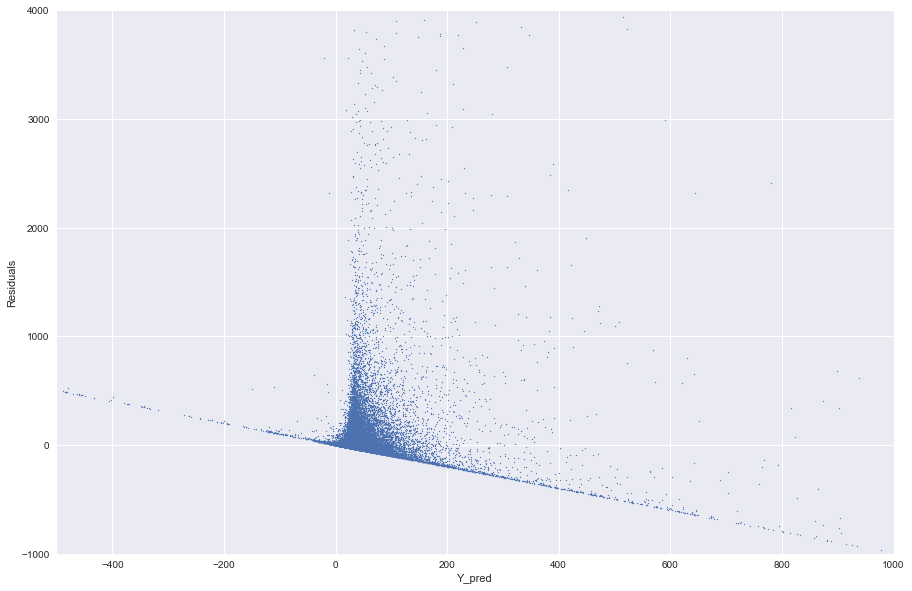

In [53]:
epsilon = Y-Y_pred
plotfig(np.array(Y_pred), np.array(epsilon),'Y_pred','Residuals')

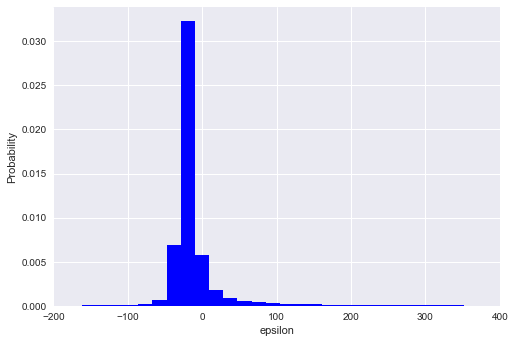

In [23]:
plt.hist(epsilon, bins=5000, facecolor = "Blue", normed=True)
plt.xlim(-200,400)
plt.xlabel('epsilon')
plt.ylabel('Probability')
plt.show()

# PART B

In [61]:
XB = X[:,[0,3]]

In [64]:
lm = LinearRegression()
model1 = lm.fit(XB,Y)
betaB = model1.coef_.tolist()
r2B = model1.score(XB, Y)
Y_predB = model1.predict(XB)
print("beta = " + str(betaB))
print("r2 = " + str(r2B))

beta = [[-0.8676173085952703, 0.8241727240053086]]
r2 = 0.0196927322993


In [65]:
print("SSE = " + str(util.getSSE(Y,Y_predB)))
print("MAPE = " + str(util.getMAPE(Y,Y_predB)))

SSE = 13490678568.4
MAPE = 550.432175793


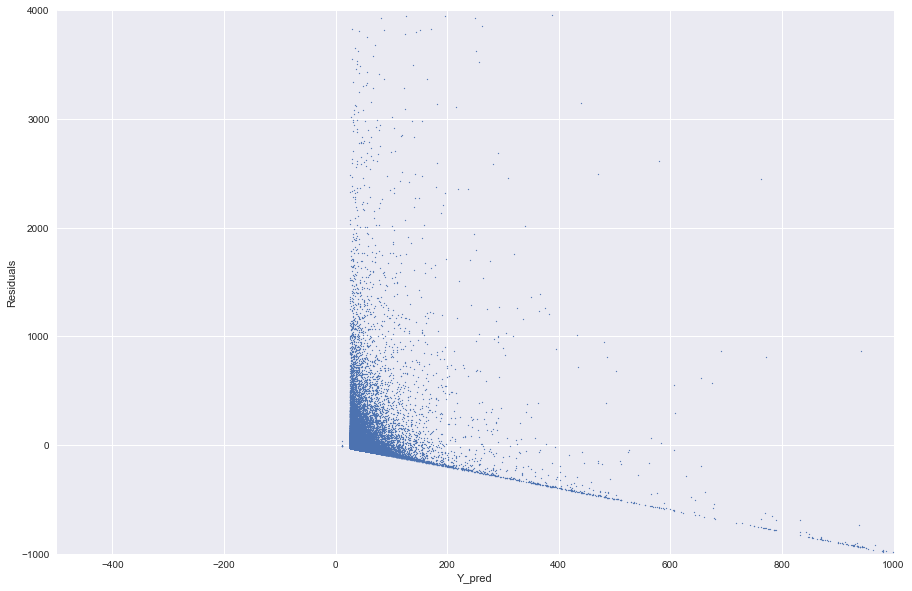

In [66]:
epsilonB = Y-Y_predB
plotfig(np.array(Y_predB), np.array(epsilonB),'Y_pred','Residuals')

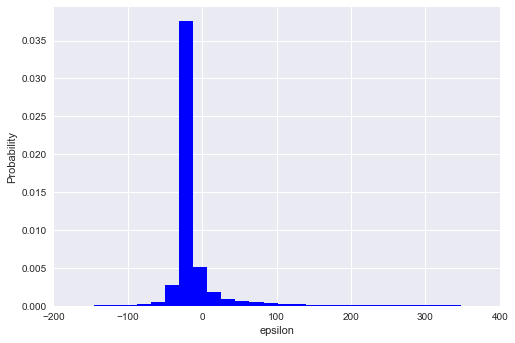

In [67]:
plt.hist(epsilonB, bins=5000, facecolor = "Blue", normed=True)
plt.xlim(-200,400)
plt.xlabel('epsilon')
plt.ylabel('Probability')
plt.show()

In [68]:
X3 = X.copy()
X3[:,0] = Y[:,0]
ncols = 6
cvalue = 0
corrs = []
for i in range(0, ncols):
    data1 = X3[:,i:i+1]
    cvalue = cvalue + 1
    for j in range(0, ncols):
        data2 = X3[:,j:j+1]
        corr, n_corr = scipy.stats.pearsonr(data1,data2)
        corrs.append(corr)

In [75]:
inv_colnames = ['Committer Date = CD','Committers Count = COC','Commit Count = CC','Files Count = FC','Language Count = LC', 'Watchers Count = WC']
colnames = ['WC', 'LC', 'FC', 'CC', 'COC', 'CD']

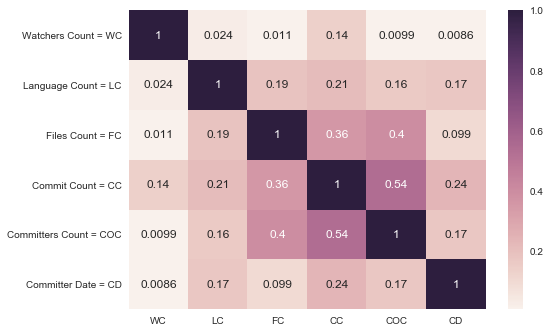

In [76]:
#creating heatmap using seaborn library
a = np.array(corrs).reshape(cvalue,cvalue)
ax = sns.heatmap(a,annot=True)
ax.set_yticklabels(inv_colnames, rotation=0)
ax.set_xticklabels(colnames)
plt.show()